In [1]:
import os
import torch
import pathlib
import itertools
import numpy as np
import pandas as pd
from torch import nn
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

2024-03-30 12:03:40.275965: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-30 12:03:40.276092: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-30 12:03:40.381137: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
class Datasets:
    def __init__(self, data_dir):
        self.data_dir = data_dir

    def define_paths(self):
        filepaths = []
        labels = []

        folds = os.listdir(self.data_dir)
        for fold in folds:
            foldpath = os.path.join(self.data_dir, fold)
            # 检查主目录中的文件夹，如果有其他文件则忽略
            if pathlib.Path(foldpath).suffix != '':
                continue

            filelist = os.listdir(foldpath)
            for file in filelist:
                fpath = os.path.join(foldpath, file)

                # 检查是否有其他文件夹
                if pathlib.Path(foldpath).suffix == '':
                    # 检查不需要的“masks"文件
                    if pathlib.Path(fpath).parts[-1] == 'masks' or pathlib.Path(fpath).parts[-1] == 'Masks' or \
                            pathlib.Path(fpath).parts[-1] == 'MASKS':
                        continue
                    else:
                        o_file = os.listdir(fpath)
                        for f in o_file:
                            ipath = os.path.join(fpath, f)
                            filepaths.append(ipath)
                            labels.append(fold)

                else:
                    filepaths.append(fpath)
                    labels.append(fold)

        return filepaths, labels

    def define_df(self, files, classes):
        Fseries = pd.Series(files, name='filepaths')
        Lseries = pd.Series(classes, name='labels')
        return pd.concat([Fseries, Lseries], axis=1)

    def split_data(self):
        files, classes = self.define_paths()
        df = self.define_df(files, classes)
        strat = df['labels']
        train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=strat)
        strat = dummy_df['labels']
        valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat)

        return train_df, valid_df, test_df

In [3]:
class DataLoaders:
    def __init__(self, train_df, valid_df, test_df, batch_size):
        self.train_df = train_df
        self.valid_df = valid_df
        self.test_df = test_df
        self.batch_size = batch_size

    def create_gens(self):
        img_size = (224, 224)
        channels = 3
        color = 'rgb'
        img_shape = (img_size[0], img_size[1], channels)

        def scalar(img):
            return img

        tr_gen = ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
        ts_gen = ImageDataGenerator(preprocessing_function=scalar)

        train_gen = tr_gen.flow_from_dataframe(
            self.train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
            color_mode=color, shuffle=True, batch_size=self.batch_size)

        valid_gen = ts_gen.flow_from_dataframe(self.valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                               class_mode='categorical',
                                               color_mode=color, shuffle=True, batch_size=self.batch_size)

        ts_length = len(self.test_df)
        test_batch_size = max(
            sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
        test_steps = ts_length // test_batch_size

        test_gen = ts_gen.flow_from_dataframe(self.test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                              class_mode='categorical',
                                              color_mode=color, shuffle=False, batch_size=test_batch_size)

        return train_gen, valid_gen, test_gen

In [4]:
class Model(nn.Module):
    def __init__(self, img_shape, num_classes):
        self.img_shape = img_shape
        self.num_classes = num_classes

    def create_model(self):
        base_model = keras.applications.VGG16(
            include_top=False,  # 不包含顶层的全连接层
            weights='imagenet',  # 在ImageNet数据集上预训练的权重
            input_shape=self.img_shape
        )
        
        # 冻结预训练模型的权重，不参与训练
        base_model.trainable = False

        self.model = keras.Sequential([
            base_model,
            layers.Flatten(),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(self.num_classes, activation='softmax')
        ])

        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return self.model

    def predict_classes(self, generator):
        y_pred = self.model.predict(generator)
        y_pred_classes = np.argmax(y_pred, axis=1)
        return y_pred_classes

In [5]:
# 使用GPU加速运算
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [6]:
# 设置数据集路径，实例化datasets，切分数据
data_dir = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset'
datasets = Datasets(data_dir)
train_df, valid_df, test_df = datasets.split_data()

# 加载数据
batch_size = 32
data_loaders = DataLoaders(train_df, valid_df, test_df, batch_size)
train_gen, valid_gen, test_gen = data_loaders.create_gens()

# 定义输入图片形状和类别总数
img_shape = (224, 224, 3)  # Adjust the image shape if necessary
num_classes = len(train_df['labels'].unique())


Found 16932 validated image filenames belonging to 4 classes.
Found 2116 validated image filenames belonging to 4 classes.
Found 2117 validated image filenames belonging to 4 classes.


In [7]:
epochs = 20

# 建立实例化深度学习模型
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # 指定使用的GPU设备编号
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"  # 启用GPU内存增长模式
model = Model(img_shape, num_classes).create_model()

# 给出网络的架构表，以及网络每层的参数，在python中将模型进行print
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/20


2024-03-30 12:05:17.439926: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.63498, expected 3.85968
2024-03-30 12:05:17.439989: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.55784, expected 5.78254
2024-03-30 12:05:17.440004: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.61282, expected 5.83752
2024-03-30 12:05:17.440019: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.34499, expected 5.56968
2024-03-30 12:05:17.440038: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.25159, expected 5.47629
2024-03-30 12:05:17.440050: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.43964, expected 4.66434
2024-03-30 12:05:17.440061: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 6.54333, expected 5.76803
2024-03-30 12:05:17.440072: E external/local_xla/xla/se

  2/530 ━━━━━━━━━━━━━━━━━━━━ 37s 72ms/step - accuracy: 0.1875 - loss: 81.7798   

I0000 00:00:1711800333.757815      81 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 70/530 ━━━━━━━━━━━━━━━━━━━━ 2:45 359ms/step - accuracy: 0.5614 - loss: 48.6936

2024-03-30 12:05:59.789950: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.46848, expected 3.68847
2024-03-30 12:05:59.790059: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 6.72762, expected 5.94762
2024-03-30 12:05:59.790075: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.00592, expected 5.22591
2024-03-30 12:05:59.790086: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.42362, expected 5.64362
2024-03-30 12:05:59.790096: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.34585, expected 4.56585
2024-03-30 12:05:59.790120: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 5.68756, expected 4.90755
2024-03-30 12:05:59.790143: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.73264, expected 4.95264
2024-03-30 12:05:59.790162: E external/local_xla/xla/se

530/530 ━━━━━━━━━━━━━━━━━━━━ 241s 412ms/step - accuracy: 0.6030 - loss: 12.7941 - val_accuracy: 0.7963 - val_loss: 0.6796
Epoch 2/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 75s 139ms/step - accuracy: 0.7117 - loss: 0.7733 - val_accuracy: 0.8223 - val_loss: 0.5410
Epoch 3/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 74s 137ms/step - accuracy: 0.7084 - loss: 0.7092 - val_accuracy: 0.8521 - val_loss: 1.7101
Epoch 4/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 74s 138ms/step - accuracy: 0.7245 - loss: 0.6952 - val_accuracy: 0.8426 - val_loss: 0.4501
Epoch 5/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 74s 137ms/step - accuracy: 0.7484 - loss: 0.6369 - val_accuracy: 0.7902 - val_loss: 0.5333
Epoch 6/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 72s 134ms/step - accuracy: 0.7619 - loss: 0.6463 - val_accuracy: 0.8549 - val_loss: 0.4241
Epoch 7/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 74s 137ms/step - accuracy: 0.7752 - loss: 0.6163 - val_accuracy: 0.8596 - val_loss: 0.4422
Epoch 8/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 72s 134ms/step - accuracy: 0.7352 - loss: 0.6584 - v

2024-03-30 12:32:28.141194: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[73,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[73,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-03-30 12:32:28.752895: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 3.75457, expected 3.27859
2024-03-30 12:32:28.752959: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 2.78673, expected 2.31075
2024-03-30 12:32:28.752970: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 3.2821, expected 2.80612
2024-03-30 12:32:28.752979: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137]

29/29 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.6846 - loss: 0.6372
Test Loss: 0.6621102690696716, Test Accuracy: 0.6915446519851685


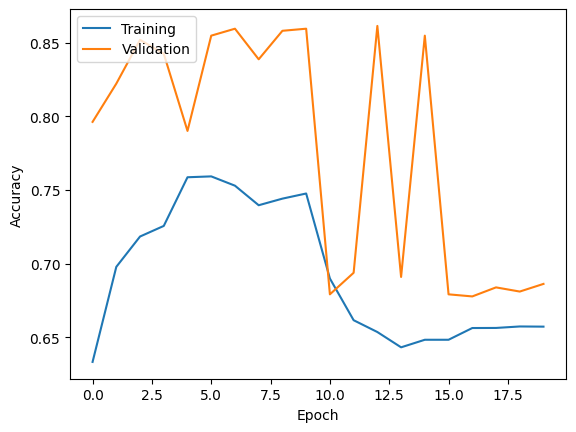

In [8]:
# 训练开始
history = model.fit(train_gen, validation_data=valid_gen, epochs=epochs)

# 评估模型
test_loss, test_acc = model.evaluate(test_gen)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')

# 绘制训练和验证的准确率
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()